# Statistics for Astronomers

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week3/04_astro_stats.ipynb)



**Author**: Priya & Najam Hasan  
**Date**: May-June 2025  
**Institution**: MANUU, Hyderabad, India

This tutorial covers advanced statistical methods commonly used in astronomical research, with practical examples using Python.

**Note**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [ ]:
!pip install numpy pandas matplotlib seaborn scipy emcee corner lifelines

## 1. Introduction

Astronomy is fundamentally a statistical science - we often deal with:
- Incomplete data (censoring, truncation)
- Measurement errors
- Low signal-to-noise observations
- High-dimensional datasets
- Complex underlying models

This tutorial will focus on practical implementation of statistical methods relevant to modern astronomy research.

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.stats as astrostats
from astropy.modeling import models, fitting
import emcee
import corner
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Probability Distributions in Astronomy

Common distributions in astronomical research:

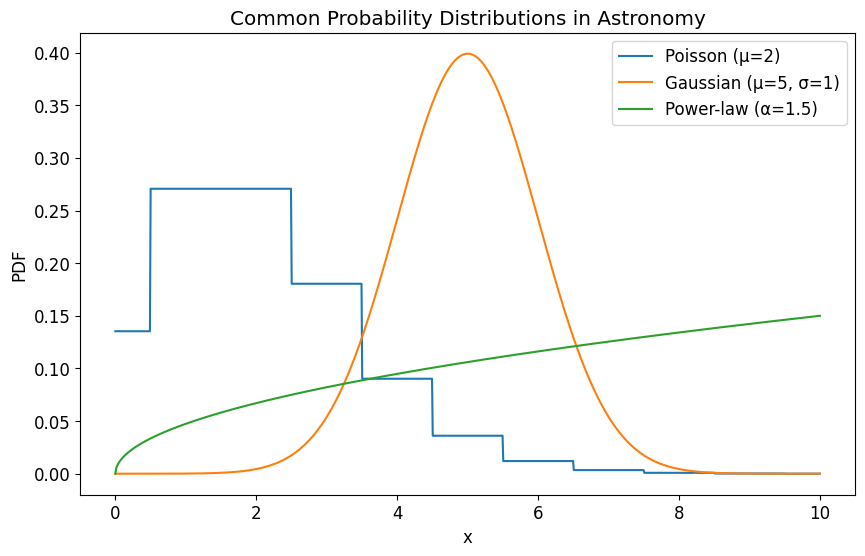

In [3]:
# Demonstrate common distributions
x = np.linspace(0, 10, 1000)

# Poisson (for counting statistics)
plt.plot(x, stats.poisson.pmf(np.round(x), mu=2), label='Poisson (μ=2)')

# Gaussian
plt.plot(x, stats.norm.pdf(x, loc=5, scale=1), label='Gaussian (μ=5, σ=1)')

# Power-law
plt.plot(x, stats.powerlaw.pdf(x, 1.5, loc=0, scale=10), label='Power-law (α=1.5)')

plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.title('Common Probability Distributions in Astronomy')
plt.show()

## 3. Bayesian Inference for Astronomical Problems

Bayesian methods are particularly valuable in astronomy where we often have:
- Prior information from previous studies
- Small sample sizes
- Complex parameter spaces

### 3.1 MCMC Sampling with emcee

Example: Fitting a line to data with heteroscedastic errors

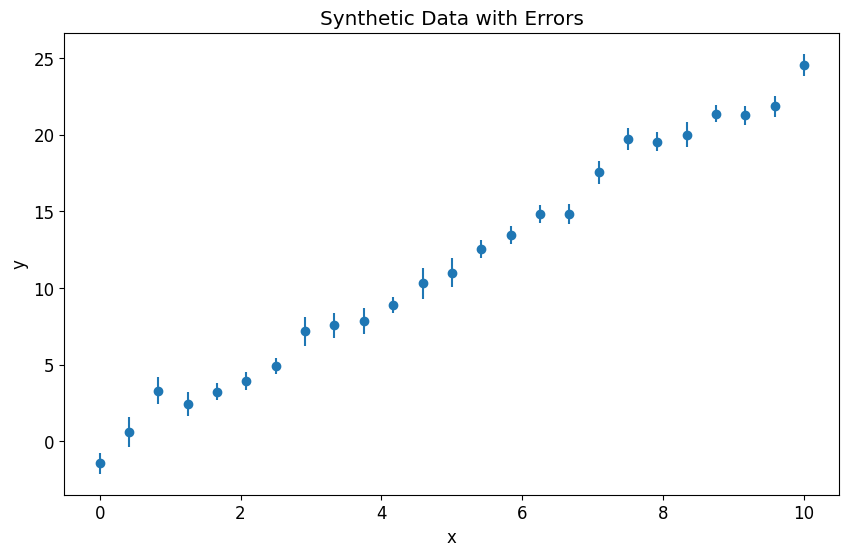

In [4]:
# Generate synthetic data
np.random.seed(42)
true_slope = 2.5
true_intercept = -1.0
x = np.linspace(0, 10, 25)
y_err = 0.5 + 0.5 * np.random.rand(len(x))
y = true_slope * x + true_intercept + y_err * np.random.randn(len(x))

plt.errorbar(x, y, yerr=y_err, fmt='o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data with Errors')
plt.show()

In [5]:
# Define log likelihood and prior
def log_likelihood(theta, x, y, yerr):
    slope, intercept = theta
    model = slope * x + intercept
    return -0.5 * np.sum(((y - model) / yerr)**2)

def log_prior(theta):
    slope, intercept = theta
    if -5.0 < slope < 5.0 and -10.0 < intercept < 10.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [6]:
# Run MCMC
pos = np.array([true_slope, true_intercept]) + 0.1 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, y_err))
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [00:01<00:00, 3479.70it/s]


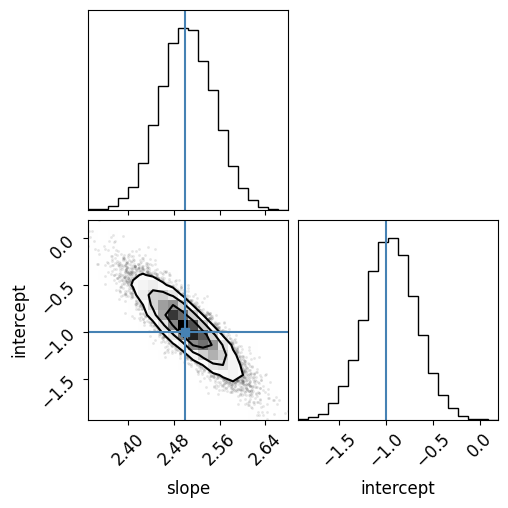

In [7]:
# Plot results
samples = sampler.get_chain(discard=100, thin=15, flat=True)

fig = corner.corner(samples, labels=['slope', 'intercept'], 
                    truths=[true_slope, true_intercept])
plt.show()

## 4. Survival Analysis for Censored Data

Astronomical data often contains upper limits (censored data). We'll use the `lifelines` package for survival analysis.

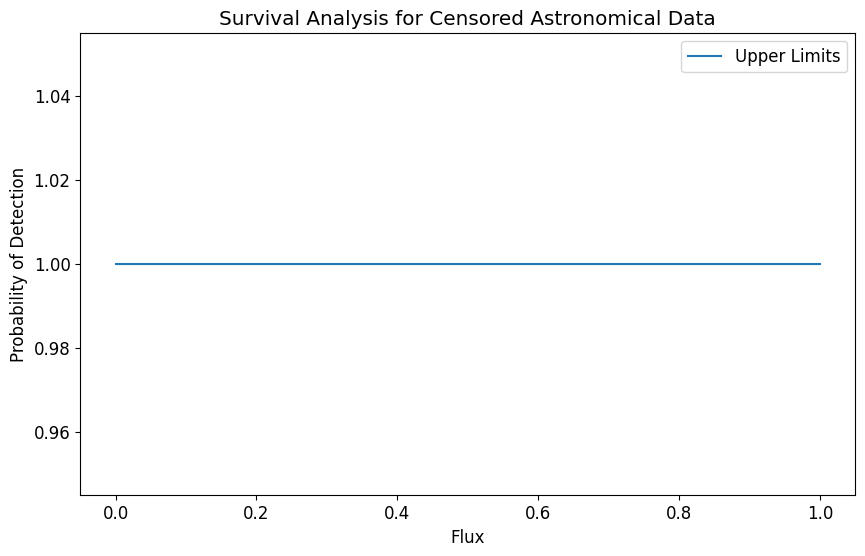

In [10]:
# Install if needed
# !pip install lifelines

from lifelines import KaplanMeierFitter

# Example: Detections and upper limits in flux measurements
flux = np.concatenate([np.random.normal(5, 1, 50), 
                       np.random.normal(0, 0.5, 30)])  # Some "non-detections"
detected = flux > 1.0  # Simple detection threshold
upper_limits = 1.0 * np.ones(sum(~detected))

kmf = KaplanMeierFitter()
kmf.fit(flux[detected], event_observed=np.ones(sum(detected)), 
        label='Detections')
kmf.fit(upper_limits, event_observed=np.zeros(sum(~detected)), 
        label='Upper Limits')

kmf.plot_survival_function()
plt.xlabel('Flux')
plt.ylabel('Probability of Detection')
plt.title('Survival Analysis for Censored Astronomical Data')
plt.show()

## 5. Time Series Analysis

Astronomical time series present unique challenges:
- Irregular sampling
- Multiple periodicities
- Non-sinusoidal signals

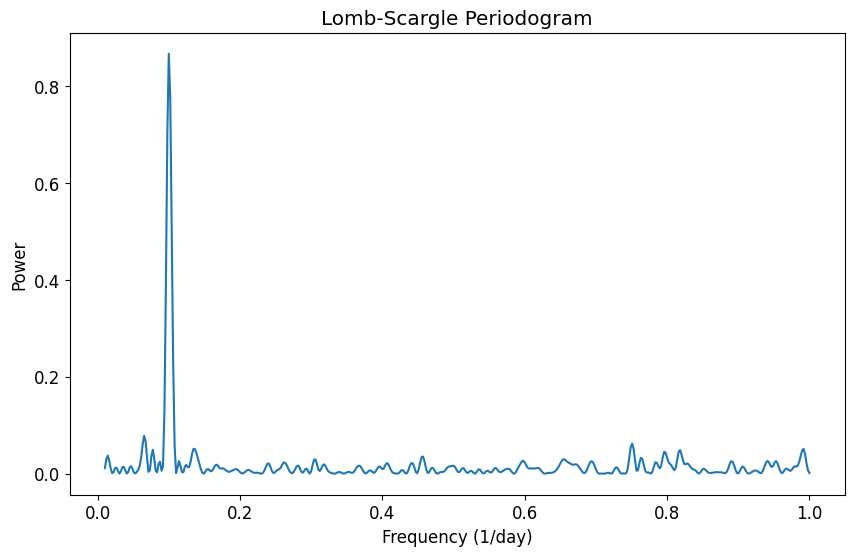

In [11]:
from astropy.timeseries import LombScargle

# Generate synthetic time series
t = np.sort(np.random.uniform(0, 100, 200))
y = 2.0 * np.sin(2 * np.pi * t / 10.0) + 0.5 * np.random.randn(len(t))

# Compute Lomb-Scargle periodogram
frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.01, 
                                              maximum_frequency=1.0)

plt.plot(frequency, power)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()

## 6. Multivariate Statistics and Dimensionality Reduction

Modern surveys produce high-dimensional data. We'll explore PCA and t-SNE.

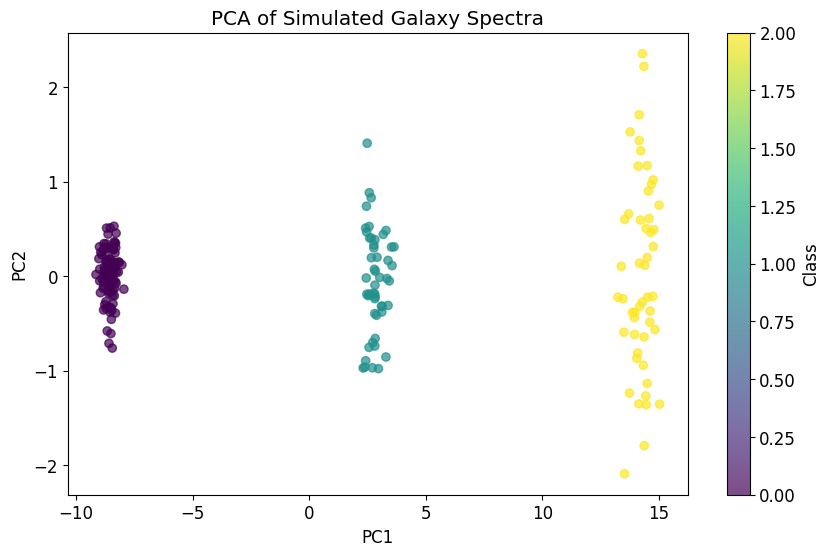

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Example: Simulated galaxy spectra with 100 wavelength bins
np.random.seed(42)
n_objects = 200
n_features = 100

# Create three classes of spectra
class1 = np.random.normal(1, 0.2, (n_objects//2, n_features))
class2 = np.random.normal(2, 0.3, (n_objects//4, n_features))
class3 = np.random.normal(3, 0.4, (n_objects//4, n_features))
X = np.vstack([class1, class2, class3])
y = np.array(['Class1']*len(class1) + ['Class2']*len(class2) + ['Class3']*len(class3))

# Standardize and apply PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Simulated Galaxy Spectra')
plt.colorbar(label='Class')
plt.show()

## 7. Machine Learning for Astronomical Classification

Brief example using random forests for classification.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Class1       1.00      1.00      1.00        31
      Class2       1.00      1.00      1.00        15
      Class3       1.00      1.00      1.00        14

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



## 8. Spatial Statistics

Analyzing the distribution of objects on the sky.

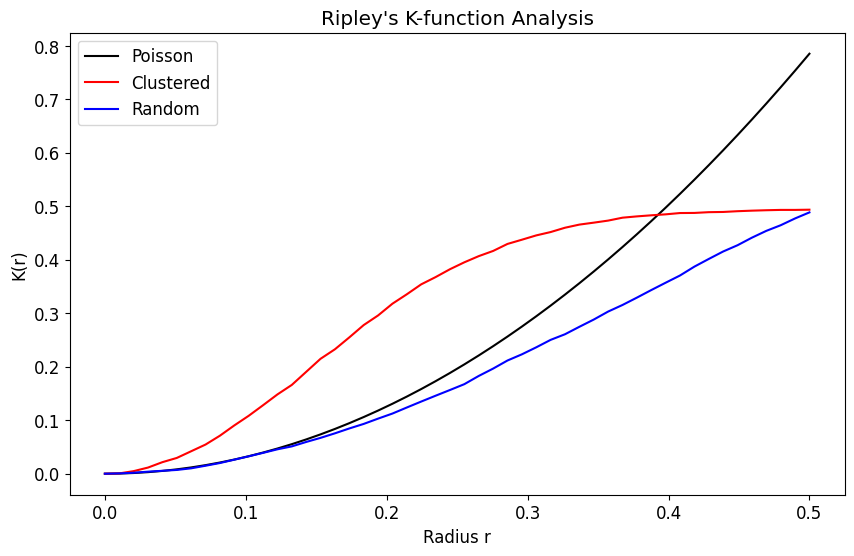

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import RipleysKEstimator

# Generate clustered and random point patterns
np.random.seed(12345)
cluster1 = np.random.normal(loc=0, scale=0.1, size=(50, 2))
cluster2 = np.random.normal(loc=1, scale=0.1, size=(50, 2))
random_points = np.random.uniform(low=0, high=1, size=(100, 2))

# Calculate K-function
Kest = RipleysKEstimator(area=1, x_max=1, y_max=1, x_min=0, y_min=0)
r = np.linspace(0, 0.5, 50)

# Calculate K values separately
K_clustered = Kest(data=np.vstack([cluster1, cluster2]), radii=r)
K_random = Kest(data=random_points, radii=r)

# Plot results
plt.plot(r, Kest.poisson(r), 'k-', label='Poisson')
plt.plot(r, K_clustered, 'r-', label='Clustered')
plt.plot(r, K_random, 'b-', label='Random')

plt.xlabel('Radius r')
plt.ylabel('K(r)')
plt.legend()
plt.title('Ripley\'s K-function Analysis')
plt.show()

## 9. Resources for Further Learning

- Feigelson & Babu: "Modern Statistical Methods for Astronomy"
- Ivezić et al.: "Statistics, Data Mining, and Machine Learning in Astronomy"
- VanderPlas: "Python Data Science Handbook" (free online)
- Astropy documentation on statistical functions
- ArXiv astro-ph.IM for latest methodological developments

## Exercises for Practice

1. Modify the MCMC example to include intrinsic scatter in the linear model
2. Apply the survival analysis methods to real astronomical data with upper limits
3. Compare PCA and t-SNE on SDSS galaxy spectra
4. Implement a Bayesian model selection approach for comparing power-law and exponential models
5. Analyze the spatial distribution of galaxies from a survey catalog